# Lab 6  - CNN
### Names:
#### Spencer Bernardo-Cheng, Rob Keehan, Max Goldstein

## Business Understanding

Our team chose a dataset including over 27,000 images of thin-blood smear slide images. The dataset is perfectly balanced between 13779 images of parasitized cells and 13,779 uninfected cells. These cell images were taken, collected, and organized from 150 P. falciparum-infected and 50 healthy patients located at Chittagong Medical College Hospital, Bangladesh, as part of an initiative to reduce the hassle for microscopists in areas of limited resources and improve diagnostic accuracy. Researchers at Lister Hill National Center for Biomedical Communications (LHNCBC), part of National Library of Medicine (NLM), started this initiative through their development of a smartphone app that can be connected to a conventional microscope. Each blood smear slide image was obtained through the use of this application and labeled by a slide reader at Mahidol-Oxford Tropical Medicine Research Unit in Bangkok, Thailand.

Our prediction task is to classify if a cell is parasitized or uninfected to speed up the process of diagnosing malaria. This classifier would provide great benefits to microscope technicians by reducing the workload of diagnosing malaria. Each technician would be able to quickly classify which cells are parasitized using our classifier in conjunction with the smartphone application developed by LHNCBC. An expert slide reader would not be needed anymore to perform proper diagnosis of Malaria. In resource limited areas, slide readers may not be directly available, and microscopists might need to send in results for review by a slide reader at another hospital. Performing this prediction task with high accuracy could let less-trained technicians or nurses diagnose Malaria in remote settings without needing to rely on a nearby slide reviewer in a hospital. Other labs attempting to predict this same task have achieved accuracies in the upper 90 percentile region. We would strive to be in this range as well. This  problem requires a high prediction accuracy because false positive and false negative diagnoses have severe consequences.


In [19]:
import pandas as pd
import numpy as np
import glob
import cv2
# stack overflow example taken from: https://stackoverflow.com/questions/37747021/create-numpy-array-of-images
X_data = []
y = []

files = glob.glob ("./cell_images/Parasitized/*.png")
for myFile in files:
    image = cv2.imread(myFile,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(128,128))
    X_data.append(image)
    y.append((int)(1))
files = glob.glob ("./cell_images/Uninfected/*.png")
for myFile in files:
    image = cv2.imread(myFile,cv2.IMREAD_COLOR)
    image = cv2.resize(image,(128,128))
    X_data.append (image)
    y.append((int)(0))
npArr =np.array(X_data)
print('X_data shape:', np.array(X_data).shape)

X_data shape: (27558, 128, 128, 3)


## Linearizing the images into a 1-d numpy array

In [23]:
print(npArr[0].shape)
print(npArr[1].shape)
pixels = npArr
pixels.shape

(128, 128, 3)
(128, 128, 3)


(27558, 128, 128, 3)

In [24]:
print(pixels.shape)

(27558, 128, 128, 3)


In [25]:
y = np.array(y)
h=128
w=128

## Visualizing the images

1


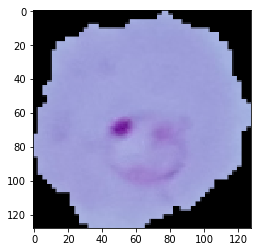

In [28]:
from matplotlib import pyplot as plt

# a helper plotting function

# def plot_gallery(images, titles, h, w,n_row=3, n_col=6):
#     """Helper function to plot a gallery of portraits"""
#     plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
#     plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
#     for i in range(n_row * n_col):
#         plt.subplot(n_row, n_col, i + 1)
#         plt.imshow(images[i])
#         plt.title(titles[i], size=12)
#         plt.xticks(())
#         plt.yticks(())
#     plt.show()
# plot_gallery(x_train, y_train, h, w) # defaults to showing a 3 by 6 subset of the faces
print(y[0])
plt.imshow(pixels[0])
plt.show()

## Metrics Used

## Data Split
We used an 80/20 split as we hade about 28,000 cell images. We don't believe that 10-fold cross validation would be necessary as the dataset is large. 

## CNN Modeling 

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Reshape
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras.regularizers import l2 
keras.__version__

'2.2.4'

In [33]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(pixels, y, test_size = 1/5, random_state = 1)
NUM_CLASSES = 2
y_train_ohe = keras.utils.to_categorical(y_train, 2)
y_test_ohe = keras.utils.to_categorical(y_test, 2)
print(x_train[:4000].shape)
print(y_train_ohe[:4000].shape)

(4000, 128, 128, 3)
(4000, 2)


In [14]:
# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=x_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(1) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(x_train, y_train, 
        batch_size=128, epochs=30, 
        shuffle=True, verbose=1)

ValueError: Error when checking input: expected dense_7_input to have 2 dimensions, but got array with shape (22046, 128, 128, 3)

In [52]:
%%time


cnn = Sequential()
# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                kernel_size=(3,3),
                input_shape = (128,128,3),
                padding='same', 
                activation='relu')) # more compact syntax
# cnn.add(MaxPooling2D(pool_size=(2, 2)))
# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2)))
    

# add one layer on flattened output
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dense(2, activation='sigmoid'))

# Let's train the model 
cnn.compile(optimizer='adam',
              loss='binary_crossentropy', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_22 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 128, 128, 64)      18496     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               33554560  
_________________________________________________________________
dense_29 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_30 (Dense)             (None, 2)                 130       
Total para

In [ ]:


# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(x_train[:1000], y_train_ohe[:1000], 
        batch_size=32, epochs=30, verbose=1,
        validation_data=(x_test[:1000],y_test_ohe[:1000]),
        callbacks=[EarlyStopping(monitor='val_loss', patience=2)])


Train on 1000 samples, validate on 1000 samples
Epoch 1/30
  32/1000 [..............................] - ETA: 3:25 - loss: 6.4228 - acc: 0.4844

In [128]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

def compare_mlp_cnn(cnn, mlp, X_test, y_test):
    plt.figure(figsize=(15,5))
    if cnn is not None:
        yhat_cnn = np.argmax(cnn.predict(np.expand_dims(X_test, axis=1)), axis=1)
        acc_cnn = mt.accuracy_score(y_test,yhat_cnn)
        plt.subplot(1,2,1)
        cm = mt.confusion_matrix(y_test,yhat_cnn)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm, annot=True, fmt='.2f')
        plt.title('CNN: '+str(acc_cnn))
    
    if mlp is not None:
        yhat_mlp = np.argmax(mlp.predict(X_test), axis=1)
        acc_mlp = mt.accuracy_score(y_test,yhat_mlp)
        plt.subplot(1,2,2)
        cm = mt.confusion_matrix(y_test,yhat_mlp)
        cm = cm/np.sum(cm,axis=1)[:,np.newaxis]
        sns.heatmap(cm,annot=True, fmt='.2f')
        plt.title('MLP: '+str(acc_mlp))

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [129]:
print(np.expand_dims(x_train[:4000], axis=1).shape)

(4000, 1, 18225)


In [159]:
%%time

# make a CNN with conv layer and max pooling
cnn2 = Sequential()
cnn2.add( Reshape((1,w,h), input_shape=(1,18225)) ) 
num_filt_layers = [32, 64]
for num_filters in num_filt_layers:
    cnn2.add( Conv2D(filters=num_filters, 
                    kernel_size=(3,3), 
                    padding='same', 
                    activation='relu',data_format="channels_first") ) # more compact syntax

    # max pooling
    cnn2.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
    

# add one layer on flattened output
cnn2.add( Dropout(0.25) ) # add some dropout for regularization after conv layers
cnn2.add( Flatten() )
cnn2.add( Dense(1024, activation='relu') )
cnn2.add( Dropout(0.5) ) # add some dropout for regularization, again!
cnn2.add( Dense(NUM_CLASSES, activation='softmax') )

cnn2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_17 (Reshape)         (None, 1, 135, 135)       0         
_________________________________________________________________
conv2d_39 (Conv2D)           (None, 32, 135, 135)      320       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 32, 67, 67)        0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 64, 67, 67)        18496     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 64, 33, 33)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 33, 33)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 69696)             0         
__________

In [66]:
cnn2.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn2.fit(np.expand_dims(x_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=10, 
        shuffle=True, verbose=1)



Epoch 1/10
22046/22046 [==============================] - 1811s 82ms/step - loss: 0.4976 - acc: 0.5024
Epoch 2/10
 2368/22046 [==>...........................] - ETA: 32:47 - loss: 0.4932 - acc: 0.5068

KeyboardInterrupt: 

In [253]:

cnn = Sequential()
# let's start with an AlexNet style convolutional phase
cnn.add(Conv2D(filters=32,
                kernel_size=(3,3), 
                input_shape = (w,h,1),
                padding='same', 
                activation='relu', data_format="channels_last")) # more compact syntax

# no max pool before next conv layer!!
cnn.add(Conv2D(filters=64,
                kernel_size=(3,3), 
                padding='same', 
                activation='relu')) # more compact syntax
cnn.add(MaxPooling2D(pool_size=(2, 2), data_format="channels_last"))
    

# add one layer on flattened output
cnn.add(Dropout(0.25)) # add some dropout for regularization after conv layers
cnn.add(Flatten())
cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5)) # add some dropout for regularization, again!
cnn.add(Dense(2, activation='softmax'))

# Let's train the model 
cnn.compile(loss='categorical_crossentropy', # 'categorical_crossentropy' 'mean_squared_error'
              optimizer='rmsprop', # 'adadelta' 'rmsprop'
              metrics=['accuracy'])

In [255]:

history = cnn.fit(np.expand_dims(x_train[:4000], axis=3), y_train_ohe[:4000], 
        batch_size=128, epochs=20, 
        shuffle=True, verbose=1,
      validation_data=(np.expand_dims(x_test[:1000], axis=3),y_test_ohe[:1000]),
      callbacks=[EarlyStopping(monitor='val_loss', patience=2)])

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
2816/4000 [====================>.........] - ETA: 1:28 - loss: 7.8978 - acc: 0.5092

KeyboardInterrupt: 

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.figure(figsize=(10,4))
plt.subplot(2,2,1)
plt.plot(history.history['acc'])

plt.ylabel('Accuracy %')
plt.title('Training')
plt.subplot(2,2,2)
plt.plot(history.history['val_acc'])
plt.title('Validation')

plt.subplot(2,2,3)
plt.plot(history.history['loss'])
plt.ylabel('MSE Training Loss')
plt.xlabel('epochs')

plt.subplot(2,2,4)
plt.plot(history.history['val_loss'])
plt.xlabel('epochs')
plt.show()

In [260]:
from sklearn import datasets, metrics
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow import set_random_seed

set_random_seed(2)
np.random.seed(0) # using this to help make results reproducible

digits = datasets.load_digits()
X = digits.data.astype(np.float32)/16.0 - 0.5
y = digits.target.astype(np.int32)

# Split it into train / test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Split X_train again to create validation data
#X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size=0.2)

X_train.shape

(1437, 64)

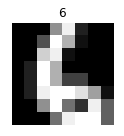

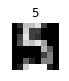

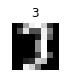

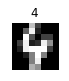

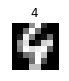

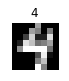

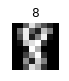

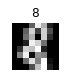

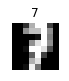

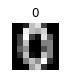

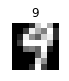

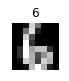

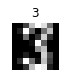

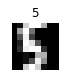

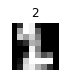

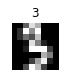

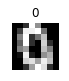

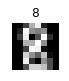

In [261]:
# What do these images look like?
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())
        plt.show()

plot_gallery(X_train, y_train, 8, 8) # defaults to showing a 3 by 6 subset of the images

In [264]:
%%time

y_train_ohe = keras.utils.to_categorical(y_train, 10)
y_test_ohe = keras.utils.to_categorical(y_test, 10)

# make a 3 layer keras MLP
mlp = Sequential()
mlp.add( Dense(input_dim=X_train.shape[1], units=30, activation='relu') )
mlp.add( Dense(units=15, activation='relu') )
mlp.add( Dense(10) )
mlp.add( Activation('softmax') )

mlp.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

mlp.fit(X_train, y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

CPU times: user 17.8 s, sys: 2.82 s, total: 20.6 s
Wall time: 14.8 s


In [266]:
%%time

# make a CNN with conv layer and max pooling
cnn = Sequential()
cnn.add( Reshape((1,8,8), input_shape=(1,64)) ) 
cnn.add( Conv2D(filters=16, kernel_size= (2, 2), padding='same', input_shape=(1,8,8),
               data_format="channels_first") )
cnn.add( Activation('relu') )
cnn.add( MaxPooling2D(pool_size=(2, 2), data_format="channels_first") )
# add one layer on flattened output
cnn.add( Flatten() )
cnn.add( Dense(10) )
cnn.add( Activation('softmax') )

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_26 (Reshape)         (None, 1, 8, 8)           0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 16, 8, 8)          80        
_________________________________________________________________
activation_30 (Activation)   (None, 16, 8, 8)          0         
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 16, 4, 4)          0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_100 (Dense)            (None, 10)                2570      
_________________________________________________________________
activation_31 (Activation)   (None, 10)                0         
Total para

In [267]:
print(X_train.shape)
# Let's train the model 
cnn.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['accuracy'])

# we need to exapnd the dimensions here to give the 
#   "channels" dimension expected by Keras
cnn.fit(np.expand_dims(X_train, axis=1), y_train_ohe, 
        batch_size=32, epochs=150, 
        shuffle=True, verbose=0)

(1437, 64)


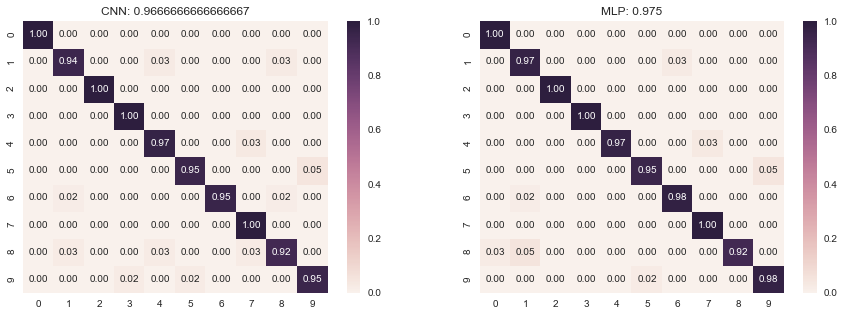

In [269]:
compare_mlp_cnn(cnn,mlp,X_test,y_test)